>[1. Introduction](#scrollTo=nLCFEsAULpHe)

>>[1.1 Dataset Overview](#scrollTo=cx_1HVIeV1rQ)

>[2. Environment Setup](#scrollTo=7ascnuQEW-3n)

>>[2.1 Import Libraries](#scrollTo=s-cyUusbXLZ4)

>>[2.2 Configurations](#scrollTo=WLAGVIZVN0mp)

>[3. Data Exploration](#scrollTo=vktm_gedYI_y)

>>[3.1 Load Dataset](#scrollTo=Qjw_haEUYi7a)

>>[3.2 Target Variable Analysis](#scrollTo=5gN_XL9IYzDk)

>>[3.3 Feature Analysis](#scrollTo=wCj3W2iOZGLL)

>>>[3.3.1 Temporal Features (season_id, month, weekday)](#scrollTo=5IJn2QpOZIaD)

>>>[3.3.2 Weather Impact Analysis](#scrollTo=FglrTRaLEGIG)

>>>>[3.3.2.1 Temperature vs. Rentals](#scrollTo=XRmJlnyREL1C)

>>>>[3.3.2.2 Humidity vs. Rentals](#scrollTo=Fu6-I-vxENh0)

>>>>[3.3.2.1 Wind Speed vs. Rentals](#scrollTo=iU7KqvlGEPOp)

>>>[3.3.3 Holiday/Working Day Analysis](#scrollTo=Vi7biFgJKIeE)

>>[3.4 Correlation Analysis](#scrollTo=VCpG3vikKnhW)

>[4. Feature Engineering](#scrollTo=h0p9P_6kP43K)

>>[4.1 Time-Based Features](#scrollTo=4azmkXv3Z3cx)

>>[4.2 Weather-Related Features](#scrollTo=O3_2J3v5bEn6)

>>[4.3 Cyclic Encoding of Time Features](#scrollTo=TqYthnNgdUmS)

>[5. Data Preprocessing](#scrollTo=oTBoLlFzLSAg)

>>[5.2 Split Traint Test](#scrollTo=mVQGO8L3NXyr)

>>[5.1 Handling Missing Values](#scrollTo=AP15zXWhLnrt)

>>[5.3 Scaling Numerical Features](#scrollTo=Orn4FpoDqTLB)

>[6. Feature Selection](#scrollTo=3pqCpXmqtEBD)

>>[6.1 Correlation Analysis](#scrollTo=a5GCWbcI6uys)

>>[6.2 Mutual Information](#scrollTo=6o4x41yc687A)

>>[6.3 ANOVA F-test](#scrollTo=Grj26d-F8Gek)

>>[6.4 Ensemble Feature Selection](#scrollTo=sPbmUKUB_Drg)

>[7. Regression](#scrollTo=VZVMtPBCApeJ)

>>[7.1 Models](#scrollTo=Wueh-b-KJvyT)

>>[7.2 Evaluation](#scrollTo=T6RNdRuHJy-_)

>>[7.3 Training and Evaluation](#scrollTo=2fY0H2NyKBbu)



# **1. Introduction**

In this project, our task is to build a regression model that predicts bike rental demand (`total_users`) based on various weather, seasonal, and calendar features. While the data is collected daily, this is not a time series forecasting task—rather, time-related features such as season, weekday, and holiday indicators will help explain patterns in rental behavior.

## 1.1 Dataset Overview

| Feature Name         | Description                                                                 | Data Type      | Example Value | Notes                                                                 |
|----------------------|-----------------------------------------------------------------------------|----------------|---------------|-----------------------------------------------------------------------|
| **id**               | Unique identifier for each record                                          | Integer        | 1, 2, 3       | Starts from 1                                                        |
| **date**             | Calendar date in `DD-MM-YYYY` format                                       | Date (String)  | 01-01-2018    | Useful for deriving day/month/year features                          |
| **season_id**        | Season of the year (categorical)                                           | Integer (1-4)  | 2 (Summer)    | 1=Spring, 2=Summer, 3=Autumn, 4=Winter                               |
| **year**             | Year encoded (0=2018, 1=2019)                                              | Integer (0-1)  | 0             | Binary encoding for the year                                         |
| **month**            | Month of the year (1-12)                                                   | Integer        | 7 (July)      |                                                                      |
| **is_holiday**       | Whether the day is a holiday (binary)                                      | Integer (0-1)  | 0             | 1=Holiday, 0=Not a holiday                                           |
| **weekday**          | Day of the week (0=Monday, 6=Sunday)                                       | Integer (0-6)  | 5 (Saturday)  |                                                                      |
| **is_workingday**    | Whether the day is a working day (binary)                                  | Integer (0-1)  | 1             | 1=Working day, 0=Non-working day                                     |
| **weather_condition**| Weather description (e.g., clear, rainy)                                   | Categorical    | "Clear"       | May need encoding (e.g., Label/One-Hot)                              |
| **temperature**      | Actual temperature in °C                                                  | Float          | 25.6          | Continuous feature                                                   |
| **feels_like_temp**  | "Feels like" temperature in °C                                            | Float          | 27.1          | Apparent temperature (may differ from actual temp)                   |
| **humidity**         | Humidity percentage (0-100%)                                              | Float          | 65.0          |                                                                      |
| **wind_speed**       | Wind speed in km/h                                                        | Float          | 12.3          |                                                                      |
| **total_users**      | **Target variable**: Total rentals (`casual_users + registered_users`)    | Integer        | 600           | **Missing in test set** (to be predicted)                            |

# **2. Environment Setup**

## 2.1 Import Libraries

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from collections import Counter

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_regression, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

## 2.2 Configurations

In [121]:
RANDOM_SEED=42

TEST_SIZE=0.2

RIDGE_ALPHA = 0.1
LASSO_ALPHA = 0.1
LASSO_MAX_ITER = 5000

RF_N_ESTIMATORS = 100

GB_PARAMS = {
    'n_estimators': 200,
    'learning_rate': 0.05,
    'max_depth': 5,
    'min_samples_split': 10,
    'subsample': 0.8
}

XGB_PARAMS = {
    'objective': 'reg:squarederror',
    'n_estimators': 300,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'gamma': 0.1
}

SVR_KERNEL = 'rbf'
SVR_C = 1.0
SVR_GAMMA = 'scale'

# **3. Data Exploration**

## 3.1 Load Dataset

In [2]:
df = pd.read_csv("regression-dataset-train.csv")

In [17]:
df.drop(["id"], axis=1, inplace=True)

In [18]:
df.head()

,date,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,total_users
0,31-07-2019,3,1,7,0,2,1,1,29.246653,33.1448,70.4167,11.083475,7216
1,03-03-2019,1,1,3,0,6,0,2,16.980847,20.6746,62.1250,10.792293,4066
2,30-12-2019,1,1,12,0,0,0,1,10.489153,11.5850,48.3333,23.500518,1796
3,28-04-2019,2,1,4,0,6,0,2,15.443347,18.8752,48.9583,8.708325,4220
4,22-04-2018,2,0,4,0,5,1,2,13.803347,16.0977,72.9583,14.707907,1683


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               510 non-null    object 
 1   season_id          510 non-null    int64  
 2   year               510 non-null    int64  
 3   month              510 non-null    int64  
 4   is_holiday         510 non-null    int64  
 5   weekday            510 non-null    int64  
 6   is_workingday      510 non-null    int64  
 7   weather_condition  510 non-null    int64  
 8   temperature        510 non-null    float64
 9   feels_like_temp    510 non-null    float64
 10  humidity           510 non-null    float64
 11  wind_speed         510 non-null    float64
 12  total_users        510 non-null    int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 51.9+ KB


In [20]:
df.describe()

,season_id,year,month,is_holiday,weekday,is_workingday,weather_condition,temperature,feels_like_temp,humidity,wind_speed,total_users
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,2.513725,0.507843,6.541176,0.025490,2.990196,0.676471,1.403922,20.108257,23.500287,63.123710,12.834912,4485.337255
std,1.110235,0.500429,3.465416,0.157763,2.017093,0.468282,0.547888,7.431626,8.090963,14.153170,5.292031,1950.666077
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,2.834381,22.000000
25%,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,13.606865,16.603063,52.270825,9.041918,3120.000000
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,20.277923,24.131150,63.437500,12.083182,4530.000000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.615847,30.177700,73.250025,15.750879,5973.500000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.041700,34.000021,8714.000000


## 3.2 Target Variable Analysis

Let's examine the distribution of our target variable `total_users`

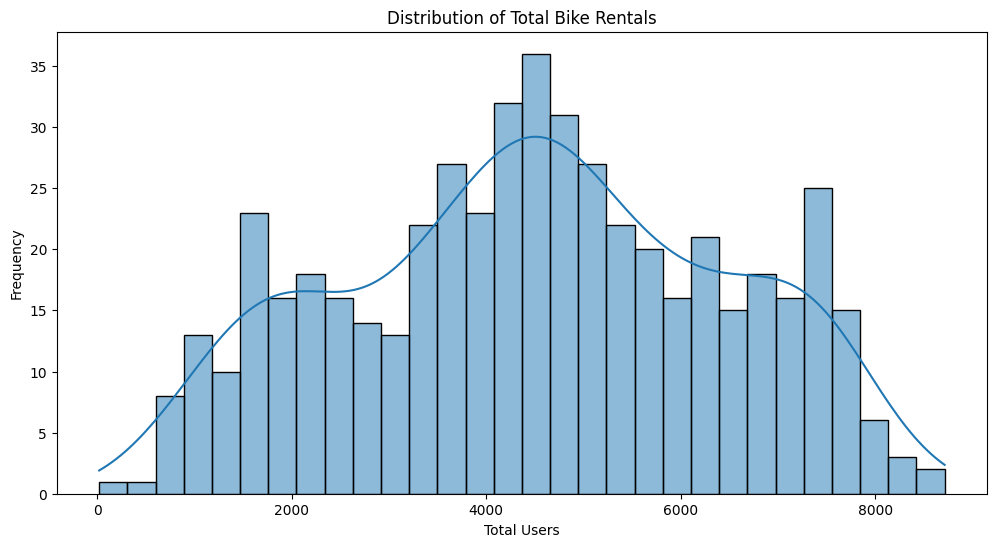

Median rentals: 4530.0
Mean rentals: 4485.3372549019605
Max rentals: 8714
Min rentals: 22


In [8]:
plt.figure(figsize=(12, 6))
sns.histplot(df['total_users'], bins=30, kde=True)
plt.title('Distribution of Total Bike Rentals')
plt.xlabel('Total Users')
plt.ylabel('Frequency')
plt.show()

print(f"Median rentals: {df['total_users'].median()}")
print(f"Mean rentals: {df['total_users'].mean()}")
print(f"Max rentals: {df['total_users'].max()}")
print(f"Min rentals: {df['total_users'].min()}")

## 3.3 Feature Analysis

### 3.3.1 Temporal Features (season_id, month, weekday)

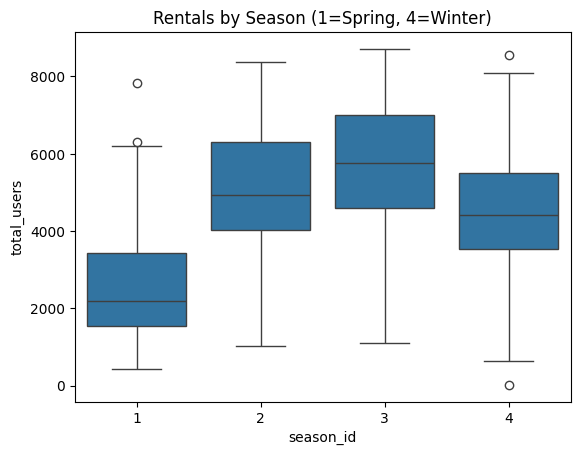

In [ ]:
sns.boxplot(x='season_id', y='total_users', data=df)
plt.title("Rentals by Season (1=Spring, 4=Winter)")
plt.show()

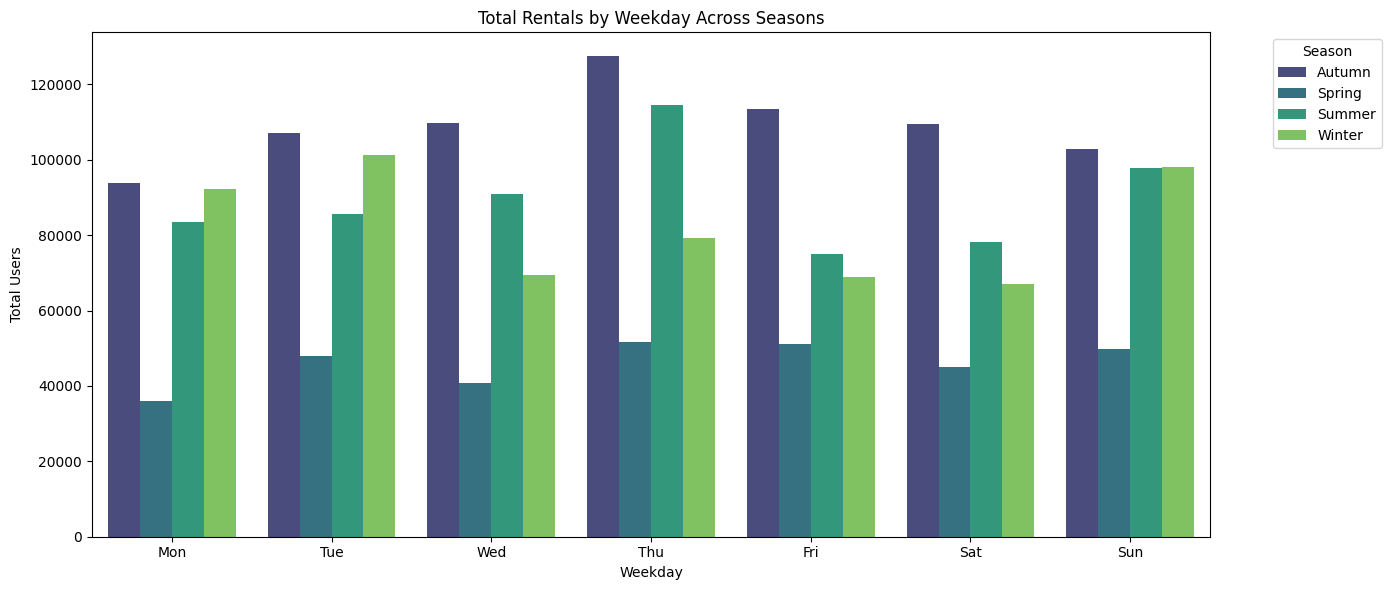

In [ ]:
copy_df = df.copy()
copy_df['date'] = pd.to_datetime(copy_df['date'], format='%d-%m-%Y')
copy_df['month'] = copy_df['date'].dt.month
copy_df['season'] = (copy_df['season_id']
                     .map({1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}))


season_weekday_sums = (copy_df
                       .groupby(['season', 'weekday'])['total_users']
                       .sum()
                       .reset_index())


plt.figure(figsize=(14, 6))
sns.barplot(
    x='weekday',
    y='total_users',
    hue='season',
    data=season_weekday_sums,
    estimator=sum,
    errorbar=None,
    palette='viridis'
)
plt.title("Total Rentals by Weekday Across Seasons")
plt.xlabel("Weekday")
plt.ylabel("Total Users")
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 3.3.2 Weather Impact Analysis

#### 3.3.2.1 Temperature vs. Rentals

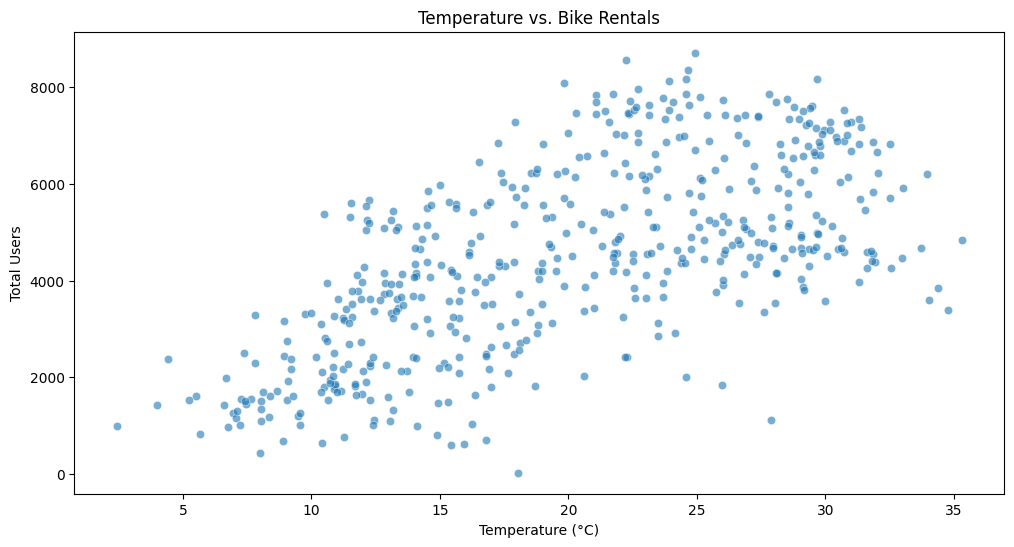

In [9]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='temperature', y='total_users', data=df, alpha=0.6)
plt.title('Temperature vs. Bike Rentals')
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Users')
plt.show()

#### 3.3.2.2 Humidity vs. Rentals

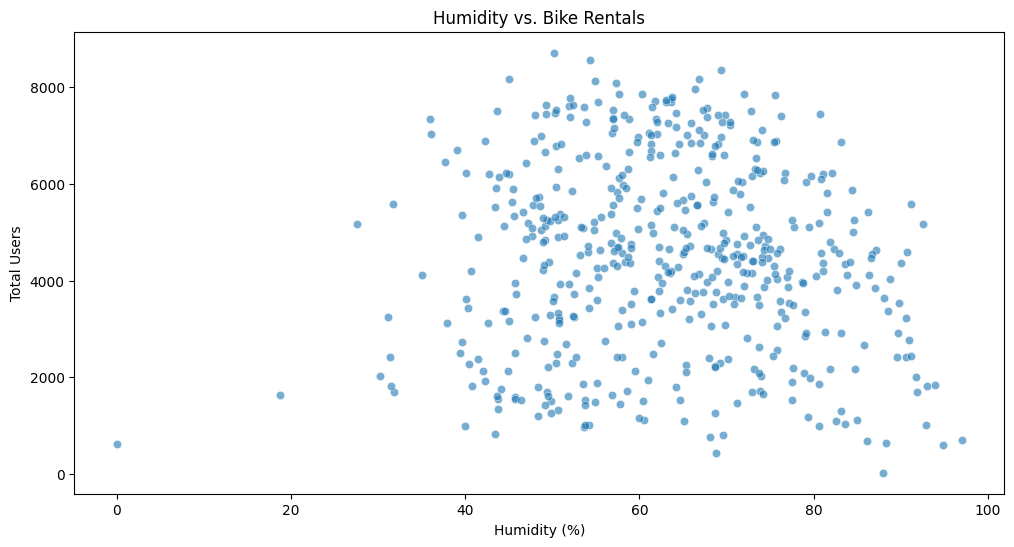

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='humidity', y='total_users', data=df, alpha=0.6)
plt.title('Humidity vs. Bike Rentals')
plt.xlabel('Humidity (%)')
plt.ylabel('Total Users')
plt.show()

#### 3.3.2.1 Wind Speed vs. Rentals

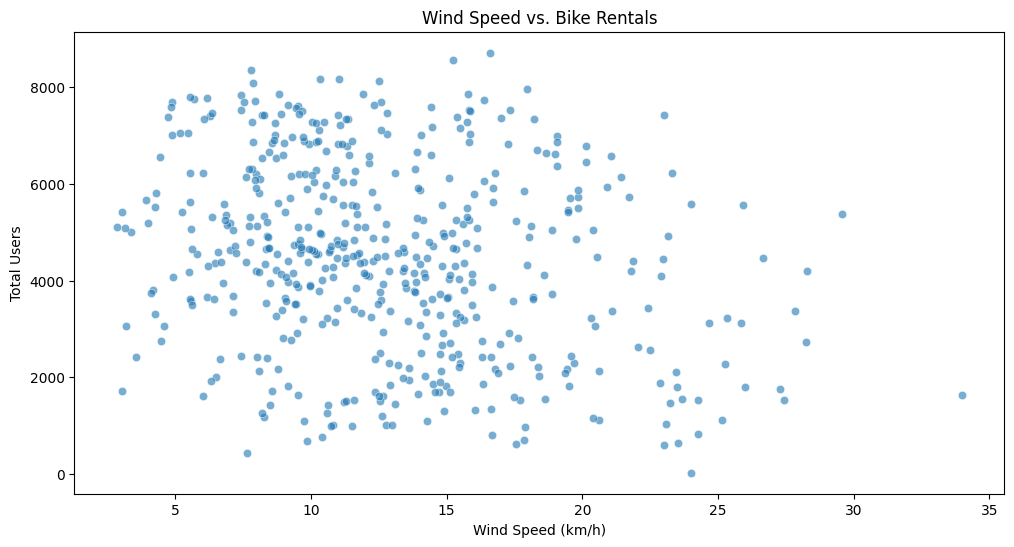

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='wind_speed', y='total_users', data=df, alpha=0.6)
plt.title('Wind Speed vs. Bike Rentals')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Total Users')
plt.show()

### 3.3.3 Holiday/Working Day Analysis

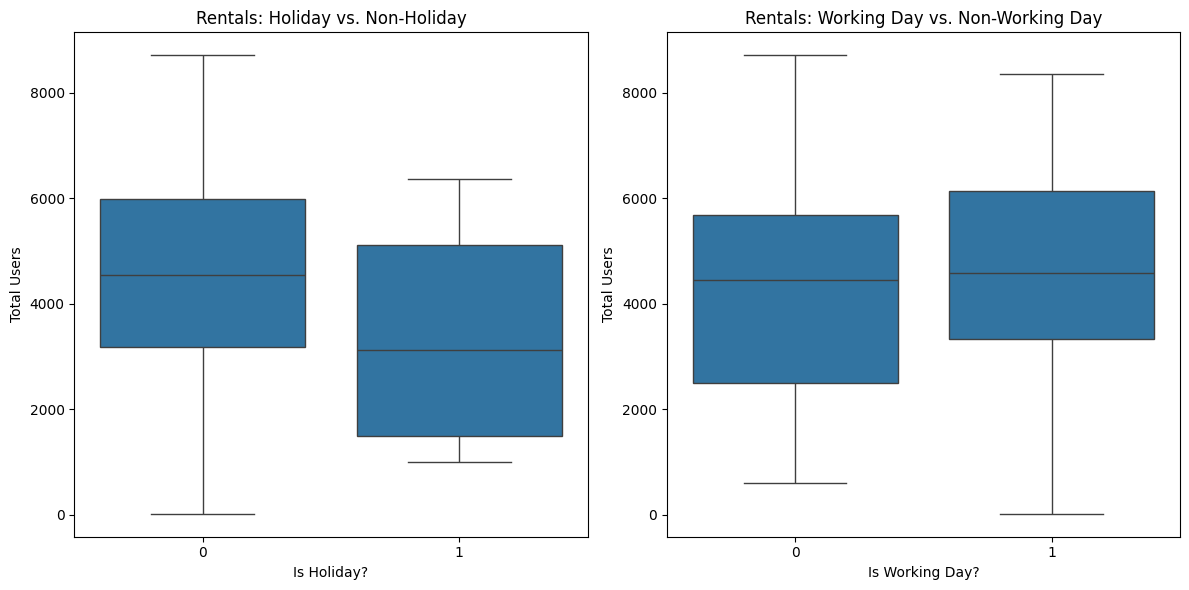

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='is_holiday', y='total_users', data=df)
plt.title('Rentals: Holiday vs. Non-Holiday')
plt.xlabel('Is Holiday?')
plt.ylabel('Total Users')

plt.subplot(1, 2, 2)
sns.boxplot(x='is_workingday', y='total_users', data=df)
plt.title('Rentals: Working Day vs. Non-Working Day')
plt.xlabel('Is Working Day?')
plt.ylabel('Total Users')

plt.tight_layout()
plt.show()

## 3.4 Correlation Analysis

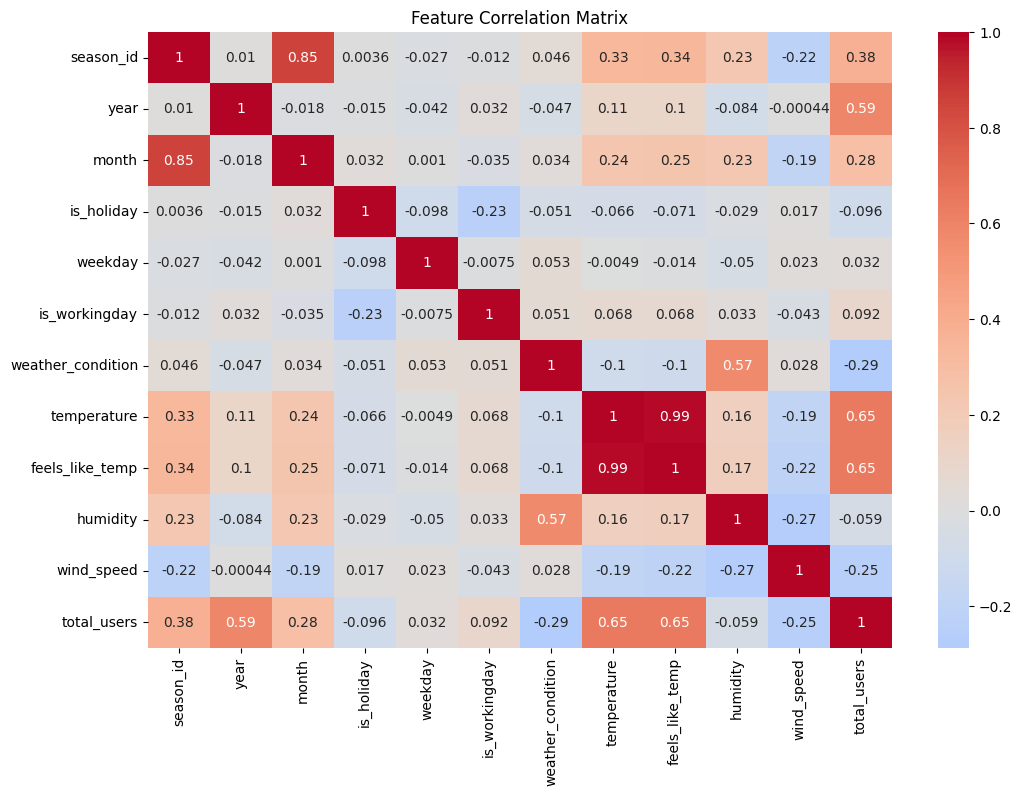

In [21]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

# **4. Feature Engineering**

In [67]:
df_copy = df.copy()

## 4.1 Time-Based Features

| Feature        | Description                                                        | Why it's Useful                                                 |
| -------------- | ------------------------------------------------------------------ | --------------------------------------------------------------- |
| `day`          | Day of the month                                                   | May capture local patterns or monthly events influencing demand |
| `day_of_year`  | Day from Jan 1 (1–365/366)                                         | Captures seasonal trends (e.g., spring/summer spike)            |
| `week_of_year` | ISO week number                                                    | Weekly trends like commute patterns or events                   |
| `holiday_weekend` | Product of `is_holiday` and `is_weekend` | Holidays on weekends might behave differently (e.g., people already off work) |



In [68]:
df_copy['date'] = pd.to_datetime(df_copy['date'], dayfirst=True)

In [69]:
df_copy['day'] = df_copy['date'].dt.day
df_copy['day_of_year'] = df_copy['date'].dt.dayofyear
df_copy['week_of_year'] = df_copy['date'].dt.isocalendar().week
df_copy['holiday_weekend'] = (df_copy['is_holiday'] & (df_copy['weekday'] >= 5)).astype(int)

## 4.2 Weather-Related Features

| Feature                     | Description                             | Why it's Useful                                                                                |
| --------------------------- | --------------------------------------- | ---------------------------------------------------------------------------------------------- |
| `temp_squared`              | Square of temperature                   | Captures **non-linear** effects (e.g., demand rises then drops in very hot weather)            |
| `feels_diff`                | `feels_like_temp - temperature`         | Measures discomfort (wind/humidity affect this), which can reduce usage                        |
| `temp_humidity_interaction` | Interaction of temperature and humidity | High humidity + heat often reduces outdoor activity                                            |
| `wind_temp_interaction`     | Wind speed × temperature                | Captures **wind chill** or **heat dispersion**, both affect user behavior                      |
| `heat_index`                | Composite measure of how hot it feels   | More accurate reflection of discomfort due to heat and humidity, key for predicting bike usage |


In [70]:
df_copy['temp_squared'] = df_copy['temperature'] ** 2
df_copy['feels_diff'] = (df_copy['feels_like_temp']
                         - df_copy['temperature'])
df_copy['temp_humidity_interaction'] = (df_copy['temperature']
                                        * df_copy['humidity'] / 100)
df_copy['wind_temp_interaction'] = (df_copy['wind_speed']
                                    * df_copy['temperature'])
df_copy['heat_index'] = df_copy.apply(
    lambda x: 0.5 * (x['temperature'] + 61.0 + ((x['temperature'] - 68.0) * 1.2) + (x['humidity'] * 0.094))
    if x['temperature'] >= 80 else x['temperature'],
    axis=1
)

## 4.3 Cyclic Encoding of Time Features

Time-related features like month, day, and weekday are cyclic (e.g., December → January). Encoding them as sine/cosine preserves this circular relationship.

| Feature                      | Description                     | Why it's Useful                                             |
| ---------------------------- | ------------------------------- | ----------------------------------------------------------- |
| `month_sin`, `month_cos`     | Encodes month (1–12) cyclically | Avoids false ordering — Dec (12) is close to Jan (1)        |
| `day_sin`, `day_cos`         | Encodes day of month cyclically | Better for capturing patterns in monthly cycles             |
| `weekday_sin`, `weekday_cos` | Encodes weekday cyclically      | Smooth modeling of weekday patterns (e.g., Monday ↔ Sunday) |


In [71]:
df_copy['month_sin'] = np.sin(2 * np.pi * df_copy['month'] / 12)
df_copy['month_cos'] = np.cos(2 * np.pi * df_copy['month'] / 12)
df_copy['day_sin'] = np.sin(2 * np.pi * df_copy['day'] / 31)
df_copy['day_cos'] = np.cos(2 * np.pi * df_copy['day'] / 31)
df_copy['weekday_sin'] = np.sin(2 * np.pi * df_copy['weekday'] / 7)
df_copy['weekday_cos'] = np.cos(2 * np.pi * df_copy['weekday'] / 7)
df_copy['day_of_year_sin'] = np.sin(2 * np.pi * df_copy['day_of_year']/365)
df_copy['day_of_year_cos'] = np.cos(2 * np.pi * df_copy['day_of_year']/365)
df_copy['week_of_year_sin'] = np.sin(2 * np.pi * df_copy['week_of_year']/52)
df_copy['week_of_year_cos'] = np.cos(2 * np.pi * df_copy['week_of_year']/52)

df_copy.drop(["month", "day", "weekday", "day_of_year", "week_of_year", "date"], axis=1, inplace=True)

# **5. Data Preprocessing**

## 5.2 Split Traint Test

In [73]:
X = df_copy.drop(columns=['total_users',])
y = df_copy['total_users']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED
)

## 5.1 Handling Missing Values

In [74]:
X_train.isnull().sum()

,0
season_id,0
year,0
is_holiday,0
is_workingday,0
weather_condition,0
temperature,0
feels_like_temp,0
humidity,0
wind_speed,0
holiday_weekend,0


In [75]:
X_test.isnull().sum()

,0
season_id,0
year,0
is_holiday,0
is_workingday,0
weather_condition,0
temperature,0
feels_like_temp,0
humidity,0
wind_speed,0
holiday_weekend,0


## 5.3 Scaling Numerical Features

In [76]:
temp_scaler = StandardScaler().set_output(transform="pandas")
humidity_scaler = MinMaxScaler().set_output(transform="pandas")
wind_scaler = RobustScaler().set_output(transform="pandas")

num_features = [
    'temperature', 'feels_like_temp', 'humidity', 'wind_speed',
    'temp_squared', 'feels_diff', 'temp_humidity_interaction',
    'wind_temp_interaction', 'heat_index'
]

X_train[num_features] = temp_scaler.fit_transform(X_train[num_features])
X_train[['humidity']] = humidity_scaler.fit_transform(X_train[['humidity']])
X_train[['wind_speed']] = wind_scaler.fit_transform(X_train[['wind_speed']])


X_test[num_features] = temp_scaler.transform(X_test[num_features])
X_test[['humidity']] = humidity_scaler.transform(X_test[['humidity']])
X_test[['wind_speed']] = wind_scaler.transform(X_test[['wind_speed']])

# **6. Feature Selection**

## 6.1 Correlation Analysis

Linear relationship strength between each feature and bike rentals `total_users`.

In [98]:
corr_scores = X_train.corrwith(y_train).abs()
top_corr_features = corr_scores[corr_scores > 0.3].index.tolist()

In [99]:
top_corr_features

['season_id',
 'year',
 'temperature',
 'feels_like_temp',
 'temp_squared',
 'feels_diff',
 'temp_humidity_interaction',
 'wind_temp_interaction',
 'heat_index',
 'month_sin',
 'month_cos',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos']

## 6.2 Mutual Information

Mutual Information measures how much knowing the value of a feature reduces uncertainty about the target.

In [89]:
mi = mutual_info_regression(X_train, y_train)
mi_scores = pd.Series(mi, index=X_train.columns)
top_mi_features = mi_scores.nlargest(10).index.tolist()

In [90]:
top_mi_features

['feels_like_temp',
 'temp_squared',
 'temperature',
 'heat_index',
 'day_of_year_cos',
 'temp_humidity_interaction',
 'feels_diff',
 'week_of_year_cos',
 'year',
 'season_id']

## 6.3 ANOVA F-test

it is a statistical test used to evaluate the linear relationship between each feature and a continuous target variable in a regression problem.

It computes:
- The F-statistic: measures how strongly each feature is linearly associated with the target.
- The p-value: estimates the statistical significance of that relationship.

In [105]:
f_values, p_values = f_regression(X_train, y_train)
top_anova_features = X_train.columns[p_values < 0.1].tolist()

In [106]:
top_anova_features

['season_id',
 'year',
 'is_holiday',
 'is_workingday',
 'weather_condition',
 'temperature',
 'feels_like_temp',
 'wind_speed',
 'temp_squared',
 'feels_diff',
 'temp_humidity_interaction',
 'wind_temp_interaction',
 'heat_index',
 'month_sin',
 'month_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos']

## 6.4 Ensemble Feature Selection

In [107]:
all_selections = top_corr_features + top_mi_features + top_anova_features
feature_counts = Counter(all_selections)

final_features = [feat for feat, count in feature_counts.items() if count >= 2]

print(f"Selected {len(final_features)} features:")
print(final_features)

Selected 14 features:
['season_id', 'year', 'temperature', 'feels_like_temp', 'temp_squared', 'feels_diff', 'temp_humidity_interaction', 'wind_temp_interaction', 'heat_index', 'month_sin', 'month_cos', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos']


# **7. Regression**

## 7.1 Models

| Model | Type | Description | Strengths | Weaknesses | Best For |
|-------|------|-------------|-----------|------------|----------|
| **Linear Regression** | Linear | Models relationship between features and target using linear equation | Simple, fast, interpretable | Assumes linearity, sensitive to outliers | Baseline modeling, when relationships are clearly linear |
| **Ridge Regression (L2)** | Regularized Linear | Linear regression with L2 penalty to reduce overfitting | Handles multicollinearity better than vanilla linear | Still assumes linearity | When features are correlated |
| **Lasso Regression (L1)** | Regularized Linear | Linear regression with L1 penalty (can zero out coefficients) | Automatic feature selection, handles multicollinearity | Tends to select only one feature from correlated groups | Feature selection in linear models |
| **Random Forest** | Ensemble (Bagging) | Builds multiple decision trees and averages their predictions | Handles non-linearity, robust to outliers | Less interpretable, can overfit | When non-linear relationships exist |
| **Gradient Boosting** | Ensemble (Boosting) | Sequentially builds trees to correct previous errors | Often more accurate than Random Forest | More prone to overfitting, slower to train | When prediction accuracy is top priority |
| **XGBoost** | Optimized Gradient Boosting | Improved gradient boosting with regularization | Fast, handles missing values, excellent performance | More hyperparameters to tune | Best overall performance in most cases |
| **Support Vector Regression (SVR)** | Kernel-based | Uses kernel trick to model non-linear relationships | Effective in high-dimensional spaces | Computationally expensive, sensitive to kernel choice | Small datasets with clear margin separation |

In [138]:
model = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=RIDGE_ALPHA),
    "Lasso Regression": Lasso(alpha=LASSO_ALPHA, max_iter=LASSO_MAX_ITER),
    "Random Forest": RandomForestRegressor(n_estimators=RF_N_ESTIMATORS,
                                           random_state=RANDOM_SEED),
    "Gradient Boosting": GradientBoostingRegressor(**GB_PARAMS,
                                                   random_state=RANDOM_SEED),
    "XGBoost": XGBRegressor(**XGB_PARAMS,
                            random_state=RANDOM_SEED),
    "Support Vector": SVR(kernel=SVR_KERNEL, C=SVR_C, gamma=SVR_GAMMA)
}

## 7.2 Evaluation

- **Mean Squared Error (MSE)**: Measures the average of the squares of errors —  
  the average squared difference between predicted and actual values.

- **Root Mean Squared Error (RMSE)**: The square root of MSE, providing error in  
  the same unit as the target variable.

- **R-Squared (R² Score)**: Indicates the proportion of the variance in the target  
  variable that is predictable from the input features. A higher R² value means  
  better model performance.

- **Mean Absolute Percentage Error (MAPE)**: Measures the accuracy as a  
  percentage of the error in predictions.

- **Mean Absolute Error (MAE)**: Measures the average magnitude of the errors  
  in a set of predictions, without considering their direction.


In [139]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)

    metrics = {
        'Model': name,
        'MSE': f"{mean_squared_error(y_test, y_pred):.1f}",
        'RMSE': f"{np.sqrt(mean_squared_error(y_test, y_pred)):.1f}",
        'R2': f"{r2_score(y_test, y_pred):.4f}",
        'MAE': f"{mean_absolute_error(y_test, y_pred):.1f}",
        'MAPE': f"{np.mean(np.abs((y_test - y_pred)/y_test))*100:.2f}%",
    }
    return metrics

## 7.3 Training and Evaluation

In [134]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    results.append(evaluate_model(name, model, X_test, y_test))

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print(results_df.to_markdown(index=False))

| Model             |              MSE |   RMSE |     R2 |    MAE | MAPE   |
|:------------------|-----------------:|-------:|-------:|-------:|:-------|
| Gradient Boosting | 453811           |  673.7 | 0.8529 |  444.4 | 14.48% |
| Linear Regression | 537520           |  733.2 | 0.8258 |  545.5 | 18.51% |
| Lasso Regression  | 540129           |  734.9 | 0.8249 |  547.7 | 18.59% |
| Ridge Regression  | 541979           |  736.2 | 0.8243 |  548.9 | 18.61% |
| Random Forest     | 583397           |  763.8 | 0.8109 |  518.9 | 17.01% |
| XGBoost           | 606090           |  778.5 | 0.8036 |  536.2 | 17.87% |
| Support Vector    |      2.58308e+06 | 1607.2 | 0.1628 | 1313.3 | 41.41% |
